

## Naive Bayes and Clustering

### Part 1: Naive Bayes

[Files](https://drive.google.com/drive/folders/1OUVrOMp2jSSBDJSqvEyXDFTrhiyZnqit?usp=sharing)

You will be performing Sentiment Analysis on a product review dataset with reviews from customers and star rating belonging to four classes (1,2,4,5). You can use sklearn for this question. Your tasks are as follows:

1.   Clean the text by removing punctations and preprocess them using techniques such as stop word removal, stemming etc. You can explore anything!
1.  Create BoW features using the word counts. You can choose the words that form the features such that the performance is optimised. Use the train-test split provided in `train_test_index.pickle` and report any interesting observations based on metrics such as accurarcy, precision, recall and f1 score (You can use Classification report in sklearn).
1. Repeat Task 2 with TfIdf features.

In [3]:
with open('train_test_index.pickle', 'rb') as handle:
    train_test_index_dict = pickle.load(handle)

# print(train_test_index_dict)
# print(train_test_index_dict.keys())

In [1]:
import pandas as pd

data = pd.read_csv('product_reviews.csv')
data.head()

,text,stars,sentiment
0,Total bill for this horrible service? Over $8G...,1.0,0
1,Went in for a lunch. Steak sandwich was delici...,5.0,1
2,This place has gone down hill. Clearly they h...,1.0,0
3,"Walked in around 4 on a Friday afternoon, we s...",1.0,0
4,Michael from Red Carpet VIP is amazing ! I rea...,4.0,1


## Using BOW


In [2]:
import numpy as np
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

In [4]:
nltk.download('stopwords')

# Function to clean and preprocess text
def preprocess_text(text):
    # Removing punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Converting to lowercase
    text = text.lower()
    # Removing stopwords and stem
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)


# Preprocessing the text
data['processed_text'] = data['text'].apply(preprocess_text)

X_train, X_test = data.loc[train_test_index_dict['train_index'], 'processed_text'], data.loc[train_test_index_dict['test_index'], 'processed_text']
y_train, y_test = data.loc[train_test_index_dict['train_index'], 'stars'], data.loc[train_test_index_dict['test_index'], 'stars']

# Creating BoW features
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Training a classifier
clf = MultinomialNB()
clf.fit(X_train_counts, y_train)

y_pred = clf.predict(X_test_counts)
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


              precision    recall  f1-score   support

         1.0       0.73      0.75      0.74      1149
         2.0       0.46      0.09      0.15       587
         4.0       0.48      0.49      0.49      1981
         5.0       0.79      0.84      0.81      5082

    accuracy                           0.70      8799
   macro avg       0.61      0.55      0.55      8799
weighted avg       0.69      0.70      0.69      8799



## Using Tf-idf

In [5]:
# Creating TF-IDF features
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.5, ngram_range=(1, 2), max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Training a classifier
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

# Predicting and evaluate
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.80      0.60      0.69      1149
         2.0       0.62      0.01      0.02       587
         4.0       0.53      0.20      0.29      1981
         5.0       0.68      0.97      0.80      5082

    accuracy                           0.68      8799
   macro avg       0.66      0.44      0.45      8799
weighted avg       0.66      0.68      0.62      8799



Observation:- TF-IDF and Bag-of-Words often don't catch the full meaning of sentences because they treat each word separately. They also can't tell if a word has different meanings in different contexts. Plus, they make really big lists of words, which can be tough for computers to handle. To improve accuracy, we might need to try different methods that understand language better.

### Part 2: Clustering

You will be performing kmeans clustering on the same product reviews dataset from Part 1. In this question, instead of statistically computing features, you will use the embeddings obtained from a neural sentiment analysis model (huggingface: siebert/sentiment-roberta-large-english).

You can use sklearn for this question. Your tasks are as follows:


1. Perform kmeans clustering using sklearn. Try various values for number of clusters (k) and plot the elbow curve. For each value of k, plot WCSS (Within-Cluster Sum of Square). WCSS is the sum of the squared distance between each point and the centroid in a cluster.
1. Perform task 1 with cluster initialisation methods [k-means++, forgy ("random" in sklearn)].
1. In this case, since the ground truth labels (star rating) are available we can evaluate the clustering using metrics like purity, nmi and rand score. Implement these metrics from scratch and evaluate the clustering. [Reference](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)

In [6]:
import gzip
import numpy as np

f = gzip.GzipFile('roberta_embeds.npy.gz', "r")
embeds = np.load(f)
print(embeds.shape)

(26661, 1024)


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.cluster import contingency_matrix
from scipy.special import comb
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


In [24]:
# Function to compute purity
def my_purity_score(labels_true, labels_pred):
    # Create a contingency table
    contingency = {}
    for t, p in zip(labels_true, labels_pred):
        if p in contingency:
            if t in contingency[p]:
                contingency[p][t] += 1
            else:
                contingency[p][t] = 1
        else:
            contingency[p] = {t: 1}

    # Sum the maximum value for each cluster
    total = sum([max(cluster.values()) for cluster in contingency.values()])

    return total / len(labels_true)


def calculate_mutual_information(predicted_labels, ratings):
    N = len(predicted_labels)
    unique_clusters = set(predicted_labels)
    unique_classes = set(ratings)
    mutual_information = 0

    for cluster in unique_clusters:
        for class_ in unique_classes:
            intersection_count = sum((np.array(predicted_labels) == cluster) & (np.array(ratings) == class_))
            cluster_count = sum(np.array(predicted_labels) == cluster)
            class_count = sum(np.array(ratings) == class_)

            if intersection_count > 0:
                mutual_information += (intersection_count / N) * np.log(N * intersection_count / (cluster_count * class_count))

    return mutual_information

def calculate_entropy(labels):
    N = len(labels)
    unique_labels = set(labels)
    entropy = 0

    for label in unique_labels:
        label_count = sum(np.array(labels) == label)
        entropy -= (label_count / N) * np.log(label_count / N)

    return entropy

def my_normalized_mutual_info_score(predicted_labels, ratings):
    mutual_information = calculate_mutual_information(predicted_labels, ratings)
    entropy_clusters = calculate_entropy(predicted_labels)
    entropy_classes = calculate_entropy(ratings)

    return mutual_information / ((entropy_clusters + entropy_classes) / 2)

def calculate_RI(predicted_labels, ratings): #for computing rand index
    N = len(predicted_labels)
    TP = TN = FP = FN = 0

    for i in range(N):
        for j in range(i + 1, N):
            same_cluster = predicted_labels[i] == predicted_labels[j]
            same_rating = ratings[i] == ratings[j]

            if same_cluster and same_rating:
                TP += 1
            elif not same_cluster and not same_rating:
                TN += 1
            elif same_cluster and not same_rating:
                FP += 1
            elif not same_cluster and same_rating:
                FN += 1

    RI = (TP + TN) / (TP + FP + FN + TN)
    return RI


def rand_index(labels_pred,labels_true): #for computing adjusted rand index
    n = len(labels_true)
    tp, fp, fn, tn = 0, 0, 0, 0

    for i in np.unique(labels_true):
        for j in np.unique(labels_pred):
            # True and predicted indices for current class and cluster
            true_indices = (labels_true == i)
            pred_indices = (labels_pred == j)

            # Count of true positives: Both true and predicted are in the same class/cluster
            tp_ij = np.sum(true_indices & pred_indices)

            # Count true positives, false positives, false negatives
            tp += tp_ij * (tp_ij - 1) // 2
            fp += tp_ij * (np.sum(pred_indices) - tp_ij)
            fn += tp_ij * (np.sum(true_indices) - tp_ij)

    # True negatives
    tn = n * (n - 1) // 2 - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

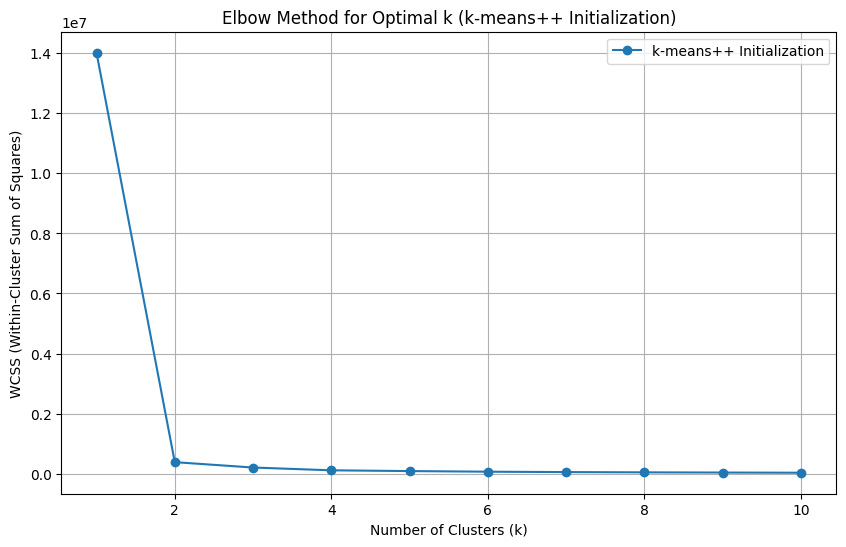

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

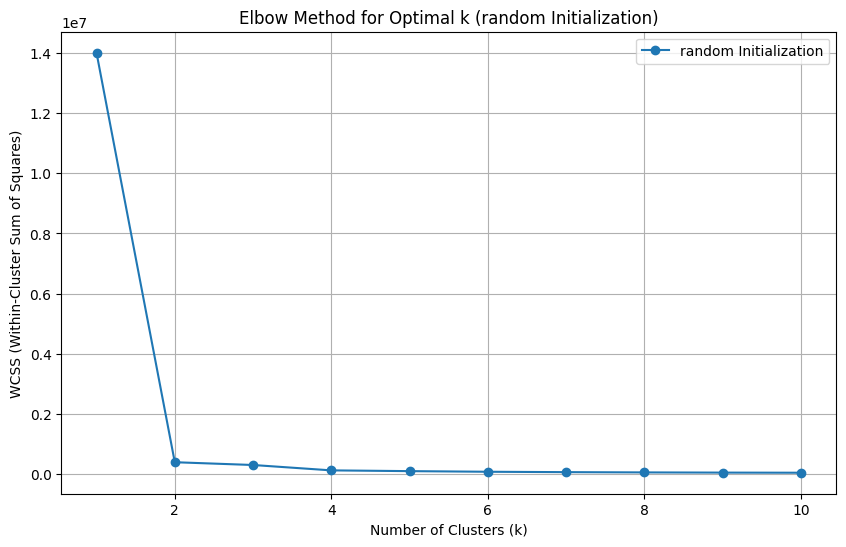

In [ ]:
# Function to calculate WCSS (Within-Cluster Sum of Squares)
def calculate_wcss(data, k, initialization):
    kmeans = KMeans(n_clusters=k, init=initialization, random_state=42)
    kmeans.fit(data)
    return kmeans.inertia_

# Function to plot the elbow curve
def plot_elbow_curve(data, initialization_method):
    ks = range(1, 11)
    wcss = [calculate_wcss(data, k, initialization_method) for k in ks]

    plt.figure(figsize=(10, 6))
    plt.plot(ks, wcss, marker='o', label=f'{initialization_method} Initialization')
    plt.title(f'Elbow Method for Optimal k ({initialization_method} Initialization)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the elbow curve for k-means++ initialization
plot_elbow_curve(embeds, 'k-means++')

# Plot the elbow curve for Forgy (random) initialization
plot_elbow_curve(embeds, 'random')



In [26]:

# Perform k-means clustering with different values of k
k_values = [2, 3, 4, 5, 6]  # Example k values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeds)
    y_pred = kmeans.labels_

    # Evaluate clustering
    purity = my_purity_score(data['stars'], y_pred)
    nmi = my_normalized_mutual_info_score(y_pred,data['stars'])
    rand = rand_index(y_pred,data['stars'])

    print(f"Metrics for k={k}: Purity={purity:.4f}, NMI={nmi:.4f}, Adjusted Rand Index={rand:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for k=2: Purity=0.7039, NMI=0.5343, Adjusted Rand Index=0.4270


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for k=3: Purity=0.7068, NMI=0.5300, Adjusted Rand Index=0.4332


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for k=4: Purity=0.7132, NMI=0.5200, Adjusted Rand Index=0.4551


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for k=5: Purity=0.7111, NMI=0.4610, Adjusted Rand Index=0.4554


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for k=6: Purity=0.7114, NMI=0.4574, Adjusted Rand Index=0.4561


In [ ]:
# rand1 = calculate_RI(y_pred,data['stars'])
# print(rand1)

In [33]:
#hello there this is inbuilt metrics
from sklearn.metrics import confusion_matrix
import numpy as np

def purity_score(y_true, y_pred):
    # Compute the contingency matrix
    contingency_matrix = confusion_matrix(y_true, y_pred)
    # Sum the maximum values of each column and divide by the total number of data points
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

from sklearn.metrics import normalized_mutual_info_score, rand_score, adjusted_rand_score
from sklearn.cluster import KMeans

# Assuming 'embeds' is your data and 'true_labels' contains the true labels
k_values = [2, 3, 4, 5, 6]  # Example k values

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeds)
    y_pred = kmeans.labels_

    # Evaluate clustering
    purity1 = purity_score(data['stars'], y_pred)
    nmi1= normalized_mutual_info_score(data['stars'], y_pred)
    rand2 = rand_score(data['stars'], y_pred)
    randa2=  adjusted_rand_score(data['stars'], y_pred)

    print(f"Metrics for k={k}: Purity={purity1:.4f}, NMI={nmi1:.4f}, Rand Score={rand2:.4f}, Adjusted Rand Score={randa2:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for k=2: Purity=0.7039, NMI=0.5343, Rand Score=0.7135, Adjusted Rand Score=0.4629


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for k=3: Purity=0.7068, NMI=0.5300, Rand Score=0.7166, Adjusted Rand Score=0.4673


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for k=4: Purity=0.7132, NMI=0.5200, Rand Score=0.7276, Adjusted Rand Score=0.4815


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for k=5: Purity=0.7111, NMI=0.4610, Rand Score=0.7277, Adjusted Rand Score=0.4549


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for k=6: Purity=0.7114, NMI=0.4574, Rand Score=0.7280, Adjusted Rand Score=0.4555
